### Rice Diseases Classification

The goal of this notebook is to build and train a model to analyze images of rice plant leaves and identify its diseases based on four categories: BrownSpot, Healthy, Hispa, and LeafBlast.



### Load Data from kaggle

In [10]:
"""from google.colab import files
files.upload()
"""

KeyboardInterrupt: 

In [9]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/minhhuy2810/rice-diseases-image-dataset
License(s): unknown
100% 12.0G/12.0G [02:06<00:00, 70.3MB/s]
100% 12.0G/12.0G [02:06<00:00, 101MB/s] 


In [11]:
!unzip rice-diseases-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_133840.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_133841.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_133953.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_133956.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134124.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134125.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134126.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134128.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134129.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134130.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2992.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2993.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2998.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2999.jpg  

### Import libraries

In [12]:
import torch
from torch import nn, optim
import numpy as np
import os
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import matplotlib.image as mpimg


%matplotlib inline


# check if cuda is available

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print('CUDA is available.  Training on GPU ...')
else:
    print('CUDA is not available!  Training on CPU ...')

CUDA is available.  Training on GPU ...


In [13]:
data_dir = './LabelledRice/Labelled'

In [14]:
images = glob(os.path.join(data_dir, '*/*.jpg'))
total_images = len(images)
print('Total images:', total_images)

Total images: 3355


In [15]:
# number of images per class
image_count = []
class_names = []

for folder in os.listdir(os.path.join(data_dir)):
    folder_num = len(os.listdir(os.path.join(data_dir, folder)))
    image_count.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)

Hispa                565
Healthy              1488
BrownSpot            523
LeafBlast            779


### Define transforms and create dataloaders

In [16]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224 + 32),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

image_datasets=dict()
image_datasets['train']=datasets.ImageFolder(data_dir,transform=data_transforms['train'])
image_datasets['valid']=datasets.ImageFolder(data_dir,transform=data_transforms['valid'])

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


# obtain training indices to use for validation
num_train = len(image_datasets['train'])
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# create dataloaders
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['valid'] = valid_loader
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}


# specify class names
class_names = image_datasets['train'].classes

### Visualize the Data

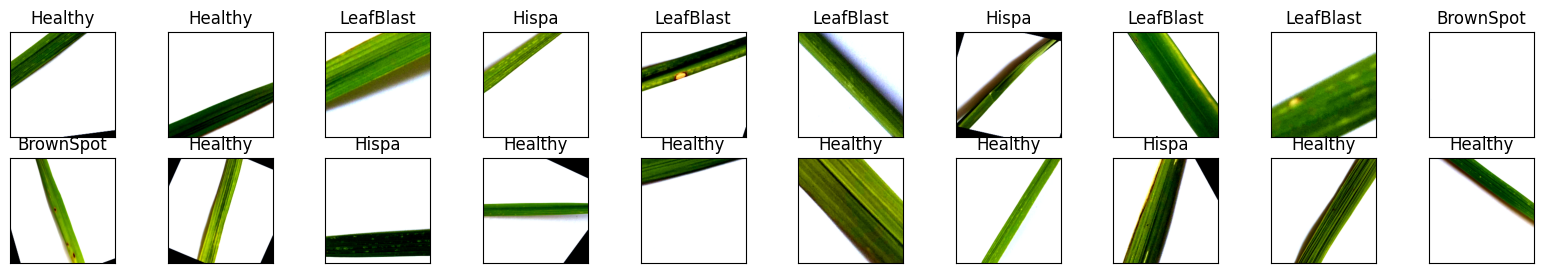

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define std and mean values
std = 0.5  # Define the standard deviation value
mean = 0.5  # Define the mean value

# helper function to un-normalize and display image
def imshow(img):
    img = img * std + mean  # Assuming std and mean are defined elsewhere
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in batch with their labels
fig = plt.figure(figsize=(20, 3))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])  # Specify 10 columns instead of 20/2
    imshow(images[idx])
    ax.set_title(class_names[labels[idx]])
plt.show()  # Don't forget to call plt.show() to display the plot


### Build and train the Classifier

Now the data is ready, we will now build the classifier, we will use pretrained models to achieve high accuracy with less time on training

In [24]:
# download the pretrained model

model_vgg = models.vgg16(pretrained=True)
for param in model_vgg.features.parameters():
    param.requires_grad = False

n_inputs = model_vgg.classifier[6].in_features
last_layer = nn.Sequential(nn.Linear(n_inputs, 512),
                                     nn.ReLU(True),
                                     nn.BatchNorm1d(512),
                                     nn.Dropout(0.5),
                                     nn.Linear(512, 4))
model_vgg.classifier[6] = last_layer


if train_on_gpu:
    model_vgg = model_vgg.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 96.8MB/s]


In [25]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training the Model

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.classifier.parameters(), lr=0.001)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_vgg.to(device);

In [27]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0


        # train the model
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            ## record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))


        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model..'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model

In [28]:
model_vgg = train(10, dataloaders, model_vgg, optimizer,
                      criterion, train_on_gpu, 'model.pt')

Epoch: 1 	Training Loss: 1.451729 	Validation Loss: 1.166850
Validation loss decreased (inf --> 1.166850). Saving model..
Epoch: 2 	Training Loss: 1.229268 	Validation Loss: 1.134211
Validation loss decreased (1.166850 --> 1.134211). Saving model..
Epoch: 3 	Training Loss: 1.173160 	Validation Loss: 1.093349
Validation loss decreased (1.134211 --> 1.093349). Saving model..
Epoch: 4 	Training Loss: 1.144384 	Validation Loss: 1.059035
Validation loss decreased (1.093349 --> 1.059035). Saving model..
Epoch: 5 	Training Loss: 1.121610 	Validation Loss: 1.071045
Epoch: 6 	Training Loss: 1.096980 	Validation Loss: 1.034939
Validation loss decreased (1.059035 --> 1.034939). Saving model..
Epoch: 7 	Training Loss: 1.091273 	Validation Loss: 1.098650
Epoch: 8 	Training Loss: 1.054731 	Validation Loss: 1.048283
Epoch: 9 	Training Loss: 1.060623 	Validation Loss: 1.067761
Epoch: 10 	Training Loss: 1.070171 	Validation Loss: 1.072484


In [29]:
# load the model that got the best validation accuracy
model_vgg.load_state_dict(torch.load('model.pt'))


<All keys matched successfully>

### Predict Plant Disease with the Model

In [42]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def predict(img_path):
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0)

    # Move input tensor to GPU if available
    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()

    prediction = model_vgg(img_tensor)
    prediction = prediction.cpu().data.numpy().argmax()

    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()

    print('Detected: {}'.format(class_names[prediction]))

In [35]:
dir_folder = '/content/LabelledRice/Labelled'
os.chdir(dir_folder)

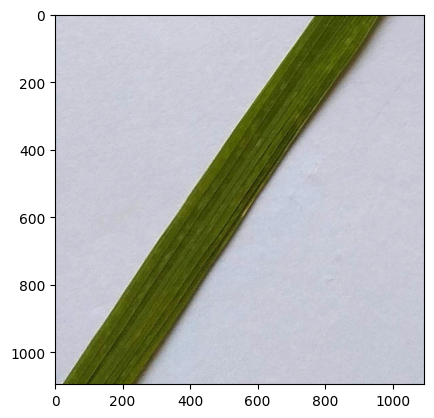

Detected: Healthy


In [43]:
file_predict1 = '/content/LabelledRice/Labelled/Healthy/IMG_20190419_135724.jpg'
predict(file_predict1)

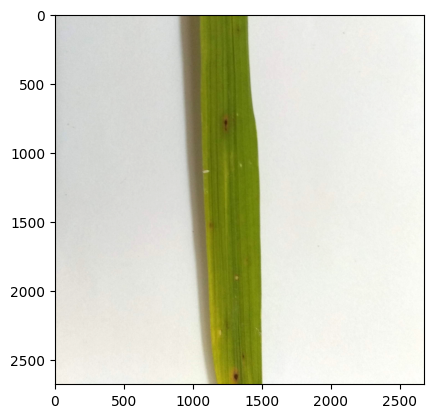

Detected: BrownSpot


In [44]:
file_predict2 = '/content/LabelledRice/Labelled/BrownSpot/IMG_20190420_195201.jpg'
predict(file_predict2)

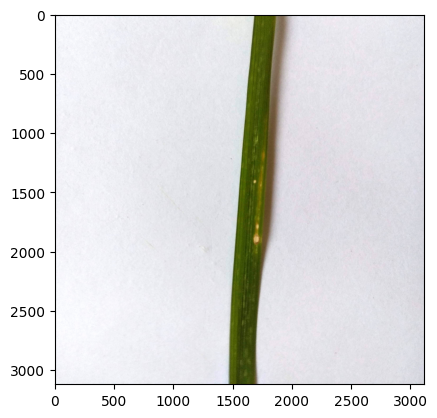

Detected: Healthy


In [45]:
file_predict3 = '/content/LabelledRice/Labelled/LeafBlast/IMG_20190419_173958.jpg'
predict(file_predict3)

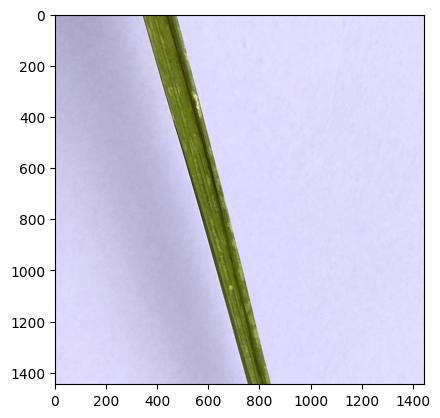

Detected: Healthy


In [46]:
file_predict4 = '/content/LabelledRice/Labelled/Hispa/IMG_20190419_105736.jpg'
predict(file_predict4)

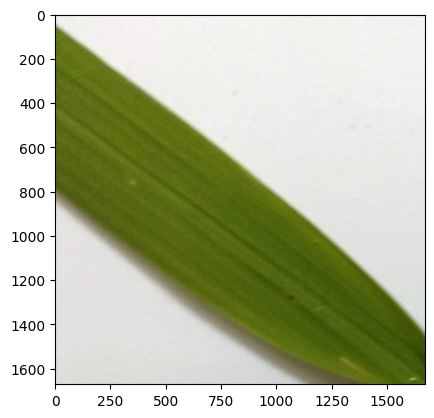

Detected: BrownSpot


In [47]:
file_predict5 = '/content/LabelledRice/Labelled/Healthy/IMG_20190420_194317.jpg'
predict(file_predict5)